In [2]:
import os
os.chdir('/content/drive/MyDrive/[IBK]job_matching')

FileNotFoundError: ignored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy
import re
from konlpy.tag import Okt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
import konlpy

In [ ]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('dg/train_df_36_4.csv')

In [ ]:
train_df[['ONSL_INRD_DTL_CON_ADJ','CRR_EPNT_DTL_CON','final_label']]

,ONSL_INRD_DTL_CON_ADJ,CRR_EPNT_DTL_CON,final_label
0,NaN,NaN,사회복지
1,안녕하세요.\r\n\r\n저는 넉넉하지는 못한 가정환경에서 태어났으나 끈임없이 도전...,부산국토관리청 진주 국도 유지발주 국도 77호선 배수개선 사업 현장대라인.\r\n수...,토목
2,NaN,NaN,디자인
3,열심히 일하겠습니다. \r\n\r\n감사합니다.,NaN,기계조립·관리
4,입사지원합니다.,NaN,생산ㆍ품질관리
...,...,...,...
18613,고객을 최고로 여기시는 부모님의 모습을 보고 배우다.\r\n\r\n 부모님께서는 ...,NaN,재무ㆍ회계
18614,한국은 잦은 트렌드 변화와 높은 수출의존도로 외풍에 취약합니다. 그러나 외풍이 예상...,"1. 인사관리\n • 근태 · 급여대장 · 연차관리, 원천세 · 연말정산, 더존스마...",총무ㆍ인사
18615,"21살 군대에서 야간경계근무중에 마음속으로 중얼거렸습니다.\r\n""적어도 지금에 나...",NaN,영업
18616,NaN,NaN,영업


In [ ]:

train_df = train_df[['ONSL_INRD_DTL_CON_ADJ','CRR_EPNT_DTL_CON','final_label']]
df = train_df.replace(np.nan,'',regex=True)
train_set = df[['ONSL_INRD_DTL_CON_ADJ','CRR_EPNT_DTL_CON']]
train_set= train_set.astype(str)
df['text']=train_set.sum(axis=1)
df['text'] = df['text'].replace('',np.nan,regex=True)
df = df.dropna(subset=['text'])
df = df.reset_index(drop = True)

df = df[['final_label', 'text']]
train = df['text']
ncs = df['final_label']

#학습 데이터의 라벨값
made = df['final_label'].unique()
made = list(made)

## 형태소 추출
komoran = konlpy.tag.Komoran()
okt = konlpy.tag.Okt()

## tokenizer : 문장에서 색인어 추출을 위해 명사,동사,알파벳,숫자 정도의 단어만 뽑아서 normalization, stemming 처리하도록 함

def komoran_tokenizer(raw, pos = ['NNG', 'NNB', 'NNP', 'NP', 'NR', 'SL']):
    return ' '.join([word for word, tag in komoran.pos(raw) if tag in pos  and len(word)>1])

#def okt_tokenizer(raw, pos = ['Noun'], stopword = stopwords):
    #return ' '.join([word for word, tag in okt.pos(raw) if tag in pos and word not in stopword and len(word)>1])

def word_prep(raw):
  return re.sub(r" +", " ",  re.sub(r"[^가-힣A-Za-z0-9]", " ", raw)).strip()

In [ ]:
df['noun'] = df['text'][:].apply(word_prep).apply(komoran_tokenizer)

In [ ]:
ple = df['noun']

In [ ]:
for i in range(len(ple)):
  ple[i] = ple[i].split(' ')

In [ ]:
lab = df['final_label']

In [ ]:
diction = pd.read_csv('1_Data/total_data/df_ncs_dict.csv')

In [ ]:
diction= diction[['job_mcn','ablt_def','fctr','hrd','occp']]
dic = diction.fillna('')
dic = dic.astype(str)
mer = dic[['ablt_def','fctr','hrd','occp']]
dic['describe'] = mer.sum(axis=1)
dic = dic[['job_mcn','describe']]
groups = dic.groupby(dic.job_mcn)
working = groups.groups
wg= list(zip(working.keys(),working.values()))
wgv = list(working.values())
work_label = []
for i in range(len(wgv)):
  work_label.append(dic.loc[wgv[i][0], 'job_mcn'])
ans = []
for i in range(len(work_label)):
  sam = dic[dic['job_mcn']==work_label[i]]['describe']
  ans.append(sam)
des = pd.DataFrame(data = list(zip(work_label,ans)),columns = ['work','desc'])

In [ ]:
ase = []
for i in range(len(des)):
  ase.append(des['desc'][i].apply(word_prep).apply(komoran_tokenizer))

In [ ]:
ho = []
for i in range(len(ase)):
  yes = []
  for j in range(len(ase[i])):
    yes.append(list(ase[i])[j].split(' '))
  ho.append(yes)

In [ ]:
for i in range(len(ho)):
  ho[i] = sum(ho[i] , [])

In [ ]:
wo = des['work']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
modeling = Word2Vec(sentences = ho, size=len(ho), window = 3, min_count = 3, workers = 4, sg = 1, iter=100)
pretrained_weights = modeling.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


In [ ]:
note = []
for i in range(len(wo)):
  a = ''.join(wo[i])
  okt = Okt()
  val = okt.nouns(a)
  note.append(val)

from nltk.corpus import stopwords
import nltk

stop_words = ["관리"]

content = []
for j in range(len(note)):
  result = []
  for i in range(len(note[j])):
    if note[j][i] not in stop_words:
      result.append(note[j][i])
  content.append(result)

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

for m in range(len(made)):
  for j in range(len(content[m])):
    for i,v in enumerate(content[m][j]):
      if len(v)<2:
            list(content[m][j]).pop(i)

In [ ]:
so = []
keys = modeling.wv.vocab.keys()
for i in range(len(content)):
  mung = []
  for j in range(len(content[i])):
    if content[i][j] in keys:
      q = modeling.wv.most_similar(content[i][j],topn = round(100/len(content[i])))
      mung.append(q)
  so.append(mung)
for i in range(len(so)):
  so[i] = sum(so[i], [])

In [ ]:
cup = []
for i in range(len(so)):
  water = []
  for j in range(len(so[i])):
    water.append(so[i][j][0])
  cup.append(water)

In [ ]:
for m in range(len(cup)):
  for i,v in enumerate(cup[m]):
      if len(v)<2:
             cup[m].pop(i)

In [ ]:
cupp = sum(cup , [])

In [ ]:
new_li = []
for i in range(len(ple)):
  n = []
  for m in range(len(ple[i])):
    if ple[i][m] in cupp:
      n.append(ple[i][m])
  new_li.append(n)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
import itertools
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_li)
X_train = tokenizer.texts_to_sequences(new_li)
#X_train = list(filter(None, X_train))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from sklearn.model_selection import train_test_split
dtrain, dtest, y_tr, y_te = train_test_split(X_train, lab, test_size = 0.2)

In [ ]:
#train의 각 자소서들의 단어 길이 패딩
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt = cnt+1
  print(max_len, (cnt/len(nested_list))*100)

max_len = 250
below_threshold_len(max_len, dtrain)

250 98.3633197910621


In [ ]:
#valid의 각 자소서들의 단어 길이 패딩
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt = cnt+1
  print(max_len, (cnt/len(nested_list))*100)

max_len = 250
below_threshold_len(max_len, dtest)

250 98.53747714808044


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_this = pad_sequences(dtrain, maxlen =250)
from tensorflow.keras.preprocessing.sequence import pad_sequences
valid_this = pad_sequences(dtest, maxlen = 250)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
encoder = LabelEncoder()
encoder.fit(lab)
labels = encoder.transform(lab)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
 
labels = encoder.transform(y_tr)
# 라벨도 원핫인코딩 해야해서 2차원 데이터로 변환합니다. 
labels = labels.reshape(-1,1)

x = to_categorical(labels, num_classes=len(wo))

In [ ]:
labelss = encoder.transform(y_te)
y = to_categorical(labelss, num_classes=len(wo))

In [ ]:
train_this.shape

(8615, 250)

In [ ]:
valid_this.shape

(2154, 250)

In [ ]:
x.shape

(8615, 79)

In [ ]:
y.shape

(2154, 79)

In [ ]:
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Embedding(input_dim=pretrained_weights.shape[0], output_dim=pretrained_weights.shape[1], weights=[pretrained_weights],trainable=False))
model.add(LSTM(256))
model.add(Dense(len(wo)))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience =5)
mc = ModelCheckpoint('best_model.h5',monitor='val_acc', mode = 'max', verbose=1, save_best_only=True)

In [ ]:
model.fit(train_this, x, epochs=50, callbacks=[es,mc], batch_size=256, validation_data=(valid_this, y))

Epoch 1/50
53/53 [==============================] - 74s 869ms/step - loss: 2.9542 - acc: 0.2673 - val_loss: 2.4136 - val_acc: 0.2858

Epoch 00001: val_acc improved from -inf to 0.28580, saving model to best_model.h5
Epoch 2/50
53/53 [==============================] - 43s 815ms/step - loss: 2.3491 - acc: 0.2992 - val_loss: 2.4019 - val_acc: 0.2897

Epoch 00002: val_acc improved from 0.28580 to 0.28965, saving model to best_model.h5
Epoch 3/50
53/53 [==============================] - 41s 779ms/step - loss: 2.3279 - acc: 0.3047 - val_loss: 2.3954 - val_acc: 0.2867

Epoch 00003: val_acc did not improve from 0.28965
Epoch 4/50
53/53 [==============================] - 42s 788ms/step - loss: 2.3259 - acc: 0.2986 - val_loss: 2.3591 - val_acc: 0.3042

Epoch 00004: val_acc improved from 0.28965 to 0.30418, saving model to best_model.h5
Epoch 5/50
53/53 [==============================] - 41s 771ms/step - loss: 2.2890 - acc: 0.3078 - val_loss: 2.3669 - val_acc: 0.2911

Epoch 00005: val_acc did not

In [ ]:
model.save('Ai_Job_Matching_algorithm(IBK-SNU)/2_JobClass_Matching_Model/1_Long_text_based_model/mnist_mlp_model.h5')

테스트

In [ ]:
import pandas as pd
import numpy as np
test_df = pd.read_csv('dg/test_df_36_4.csv')

In [ ]:
test_df = test_df[['ONSL_INRD_DTL_CON_ADJ','CRR_EPNT_DTL_CON','final_label']]
df = test_df.replace(np.nan,'',regex=True)
test_set = df[['ONSL_INRD_DTL_CON_ADJ','CRR_EPNT_DTL_CON']]
test_set= test_set.astype(str)
df['text']=test_set.sum(axis=1)
df['text'] = df['text'].replace('',np.nan,regex=True)
df = df.dropna(subset=['text'])
df = df.reset_index(drop = True)

df = df[['final_label', 'text']]
test = df['text']
ncs = df['final_label']

made = df['final_label'].unique()
made = list(made)

## 형태소 추출
komoran = konlpy.tag.Komoran()
okt = konlpy.tag.Okt()

## tokenizer : 문장에서 색인어 추출을 위해 명사,동사,알파벳,숫자 정도의 단어만 뽑아서 normalization, stemming 처리하도록 함
def komoran_tokenizer(raw, pos = ['NNG', 'NNB', 'NNP', 'NP', 'NR', 'SL']):
    return ' '.join([word for word, tag in komoran.pos(raw) if tag in pos and len(word)>1])

def word_prep(raw):
  return re.sub(r" +", " ",  re.sub(r"[^가-힣A-Za-z0-9]", " ", raw)).strip()

In [ ]:
df['noun']=df['text'][:].apply(word_prep).apply(komoran_tokenizer)

In [ ]:
wordd = df['noun']

In [ ]:
for i in range(len(wordd)):
  wordd[i]=wordd[i].split(' ')

In [ ]:
te = list(wordd)

In [ ]:
ne = []
for i in range(len(wordd)):
  n = []
  for m in range(len(wordd[i])):
    if wordd[i][m] in cupp:
      n.append(wordd[i][m])
  ne.append(n)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
dg = tokenizer.texts_to_sequences(wordd)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(dg, maxlen = 250)

In [ ]:
X

array([[  0,   0,   0, ...,  10, 213, 217],
       [  0,   0,   0, ...,   1,  39, 221],
       [  0,   0,   0, ..., 102,   5,  78],
       ...,
       [  0,   0,   0, ...,   1,  12,  30],
       [  0,   0,   0, ..., 156,  51,  15],
       [  0,   0,   0, ...,  22,  34,  55]], dtype=int32)

In [ ]:
answer = []
pre = []
pred_out = model.predict(X)
for i in range(len(pred_out)):
  answer.append(np.argmax(pred_out[i]))
  pre.append(np.max(pred_out[i]))

In [ ]:
predict_label = encoder.inverse_transform(answer)

In [ ]:
df['predict_label']= predict_label

In [ ]:
df['predict_weight']= pre

In [ ]:
true_ans = df['final_label']

In [ ]:
df[['predict_label','predict_weight']].to_csv('Ai_Job_Matching_algorithm(IBK-SNU)/2_JobClass_Matching_Model/1_Long_text_based_model/Long_Text_Test_Result_04.csv')

In [ ]:
c = 0
for i in range(len(predict_label)):
  if list(true_ans)[i]==predict_label[i]:
    c += 1
    
print(c/len(list(true_ans)))

In [ ]:
df[['final_label','predict_label','text']]

,final_label,predict_label,text
0,디자인,디자인,"높을 고, 밝을 혜, 보배 진, 이란 이름으로 밝고 보배롭게 자라라는 뜻으로 이름을..."
1,생산ㆍ품질관리,생산ㆍ품질관리,- <역지사지 외동아들> -\r\n집에 혼자 지내는 시간이 많아 친구들을 많이 좋아...
2,영업,영업,"[성장한 가정환경, 본인가족 현황] \r\n 2남 4녀 중 넷째 장남으로 태어났습..."
3,생산ㆍ품질관리,생산ㆍ품질관리,"저는 전공으로 광계측분야를 연구하면서 여러 덕목을 훈련했습니다. 우선, 광계측분야는..."
4,보건,영업,안녕하세요\r\n저는 이미송입니다\r\n\r\n최선을 다하겠습니다\r\n이쁘게 봐주세요
...,...,...,...
2715,생산ㆍ품질관리,영업,<성장배경>\n&quot;사람이 사람다워야 한다&quot; 이 말은 제가 살아오면서...
2716,인쇄ㆍ출판,영업,안녕하십니까 여름같은 남자 김경원입니다. 저는 인천부평공업고등학교3학년입니다. 여름...
2717,영업,생산ㆍ품질관리,"-성격의 장, 단점\r\n\r\n 긍정적이고 낙천적인 성격을 가지고 있습니다. 어렵..."
2718,건축,영업,"""소통하는 사람이어라""\r\n\r\n건축 Engineer로서 타 부서와의 협업능력은..."


In [ ]:
df[['final_label','predict_label','text']][1500:]

,final_label,predict_label,text
1500,건축,영업,성장과정\r\n저는 보수적인 아버지와 자상하신 어머니 사이에서 태어났습니다. 어렸을...
1501,영업,총무ㆍ인사,성장과정: [소통의 기본을 아는 커뮤니케이터]\r\n\r\n 2010년 9월부터 3...
1502,영업,영업,"1. 성장과정\r\n\r\n 1971년, 서울에서 1남 1녀 중 막내로 태어났습니다..."
1503,영업,영업,"-자기소개-\r\n등산, 서예 등 많은 경험을 하길 원하셨던 부모님의 영향으로 도전..."
1504,기계설계,생산ㆍ품질관리,안녕하십니까. 저는 국가에 몸받쳐 경찰관을 하셨던 아버지와 아버지가 과로로인해 불치...
...,...,...,...
2687,영업,영업,-성장 배경\r\n\r\n저는 1983년 4월 30일에 엄하시지만 따뜻하신 아버지와...
2688,경비,영업,열심히하겠슴니다.
2689,영업,생산ㆍ품질관리,- 끈기 있는 인재 -\r\n 고등학교 때에 산악반에 들어갔습니다. 산악반을 통해 ...
2690,전기,생산ㆍ품질관리,[■ 직무경험]\n\n건축공학과를 전공하고 건축 현장 및 설계 업무를 하다 어렸을 ...


In [ ]:
c = 0
for i in range(len(df)):
  if df['predict_label'][i]=='생산ㆍ품질관리':
    c += 1
print(c)

525


In [ ]:
df['text'][1504]

'안녕하십니까. 저는 국가에 몸받쳐 경찰관을 하셨던 아버지와 아버지가 과로로인해 불치병에 걸려\r\n형과 저를 지금 까지 키워주신 어머니 곁에서 자란 예상민입니다.\r\n저의 아버지는 10녀는 동안 경찰관을 하시면서 노무부장관 상을 포함하여 표창장을 100여개 가량\r\n받아가시면서  빠른 진급을 하셨으나 과로로 인하여 척추에 마비로 쓰려지셨습니다. 현재 아버지는\r\n그뒤로 거동은 많이 불편 하시지만. 아버지가 경찰관을 하시면서 열심히 일하셨던 것에는 뿌듯함을\r\n가지고 계셨습니다. 저는 아버지의 그런 모습을 보고 저의 좌우명을 정하였습니다. "항상 최선을\r\n다하자","내가 싫은 일은 남도 싫어 한다. 내가 나서서 하는것이 좋다" \r\n저는 아버지 처럼 가족과 회사에 최선을 다하고 싶습니다. \r\n저의 성격은 제가 글로 써서 심사관님이 보시게 되면 다른 사람과 똑 같네 라고 생각 하실수 있기에\r\n저는 이렇게 말씀 드리고 싶습니다. 저의 성격은 회사에 많은 도움이 되는 성격을 가지고 있습니다\r\n왜냐하면 저는 사람을 힘들게 하기보다는 즐겁게하는 성격이기 때문입니다. 즐겁게 한다는말은 제가\r\n재롱이나 개그를 해서 웃기는게 아니라 일을 하면서 질적으로 즐겁게 일할수있도록 많은 도움을 주기 \r\n때문입니다. 하나 예를 들자면 한사람이 "아 귀찮다" 라고 말을 했을때 저는 "에고 귀찮으면 우째요~\r\n나중의 행복을 위해 고고싱~ 쪼금 있으면 퇴근이잖아요~ 힘냅시다" 라고 합니다. 그때 그때 상황에\r\n따라 여러가지 방법이 있겠지만 저는 이런 성격을 지니고 있습니다.'

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
!pip install wordcloud
!pip install matplotlib

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Twitter
from collections import Counter
import matplotlib 
from IPython.display import set_matplotlib_formats 

matplotlib.rc('font',family = 'Malgun Gothic') 

set_matplotlib_formats('retina') #그래프가 한글일 경우 선명하게 나오지 않아 선명하게 하기(retina)

matplotlib.rc('axes',unicode_minus = False)

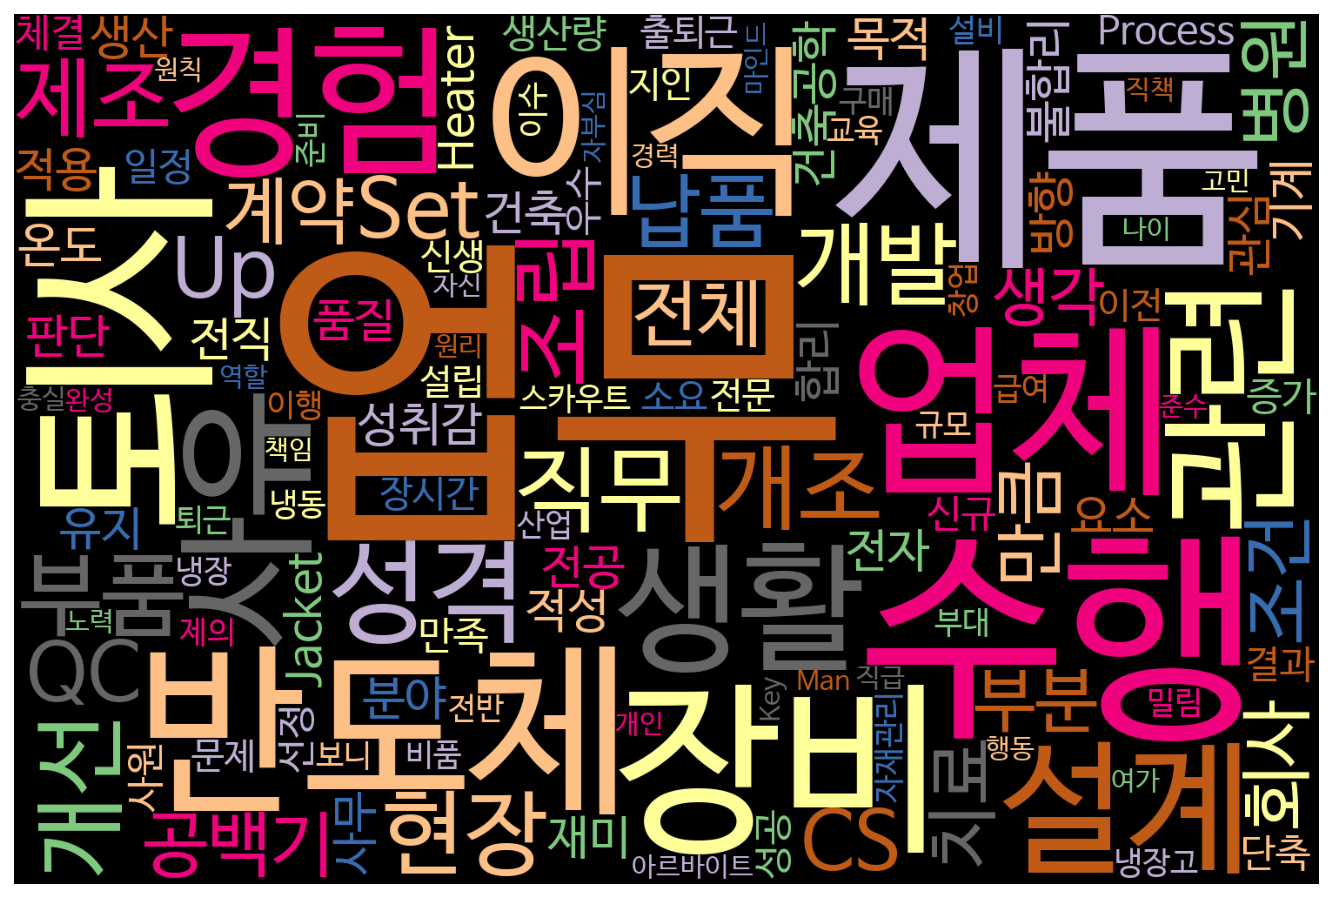

In [ ]:
count = Counter(wordd[2690])
A= dict(count.most_common())
wordcloud = WordCloud(font_path= fontpath, background_color='black',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(A)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
for i in range(len(ho)):
  count = Counter(ho[i])
  A= dict(count.most_common())
  wordcloud = WordCloud(font_path= fontpath, background_color='black',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(A)
  plt.figure(figsize=(16,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()